# 15. Transfer Learning with Inception v3

In [1]:
import torch
import torch.nn as nn

from torchvision import models
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision.utils
import torch.utils.data as Data

import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 15.1 Prepare Data

In [3]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

batch_size = 5

train_data = dsets.ImageFolder('./data/squir_chip_data/train/', train_transform)
test_data = dsets.ImageFolder('./data/squir_chip_data/val', test_transform)

train_loader = Data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = Data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)

In [4]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

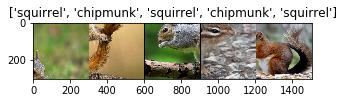

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images, normalize=True), [train_data.classes[i] for i in labels])

## 15.2 Define Model

In [6]:
model = models.inception_v3(pretrained=True)

In [7]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [8]:
model.aux_logits = False

fine_tune = False

if not fine_tune:
    for parameter in model.parameters():
        parameter.requires_grad = False

In [9]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 10),
    nn.Linear(10, 2)
)

In [10]:
model = model.cuda()

In [11]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

## 15.3 Train Model

In [12]:
num_epochs = 30

In [13]:
for epoch in range(num_epochs):

    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 5 == 0:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, cost.item()))

Epoch [1/30], lter [5/28] Loss: 1.4898
Epoch [1/30], lter [10/28] Loss: 0.5822
Epoch [1/30], lter [15/28] Loss: 0.5643
Epoch [1/30], lter [20/28] Loss: 0.8838
Epoch [1/30], lter [25/28] Loss: 0.5295
Epoch [2/30], lter [5/28] Loss: 0.4088
Epoch [2/30], lter [10/28] Loss: 0.2974
Epoch [2/30], lter [15/28] Loss: 0.4507
Epoch [2/30], lter [20/28] Loss: 0.5129
Epoch [2/30], lter [25/28] Loss: 1.1330
Epoch [3/30], lter [5/28] Loss: 0.9266
Epoch [3/30], lter [10/28] Loss: 0.3043
Epoch [3/30], lter [15/28] Loss: 0.5164
Epoch [3/30], lter [20/28] Loss: 0.3939
Epoch [3/30], lter [25/28] Loss: 0.4376
Epoch [4/30], lter [5/28] Loss: 0.6928
Epoch [4/30], lter [10/28] Loss: 0.2184
Epoch [4/30], lter [15/28] Loss: 0.3188
Epoch [4/30], lter [20/28] Loss: 0.3287
Epoch [4/30], lter [25/28] Loss: 0.3058
Epoch [5/30], lter [5/28] Loss: 0.1398
Epoch [5/30], lter [10/28] Loss: 0.4732
Epoch [5/30], lter [15/28] Loss: 0.8439
Epoch [5/30], lter [20/28] Loss: 0.3464
Epoch [5/30], lter [25/28] Loss: 0.5227
Epoch

## 15.4 Test Model

In [14]:
# model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 92.000000 %


In [15]:
classes = ["Squirrel", "Chipmunk"]

Predicted:  Chipmunk Chipmunk Chipmunk Chipmunk Squirrel


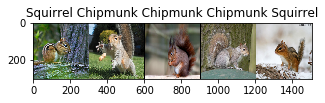

In [16]:
images, labels = iter(test_loader).next()

outputs = model(images.cuda())

_, predicted = torch.max(outputs.data, 1)
    
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(5)))

title = (' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images, normalize=True), title)